In [1]:
%pylab inline
import sys

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import arviz as az

import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.font_manager as fm

rcParams['font.family'] = 'sans-serif'

sys.path.append('../')
from mederrata_spmf import PoissonMatrixFactorization


Populating the interactive namespace from numpy and matplotlib


# Generate a count matrix of random noise

We want our factor model to tell us that this is just noise

In [2]:
N = 50000
D = 20
P = 3

# Test taking in from tf.dataset, don't pre-batch
data = tf.data.Dataset.from_tensor_slices(
    {
        'data': np.random.poisson(3.0, size=(N, D)),
        'indices': np.arange(N),
        'normalization': np.ones(N)
    })

data = data.batch(1000)


Currently, the input data has to be in this format, as a tensorflow BatchDataset object with the given key/values.

# Set up the inference object

In [3]:
# strategy = tf.distribute.MirroredStrategy()
strategy = None
factor = PoissonMatrixFactorization(
    data, latent_dim=P, strategy=strategy,
    encoder_function=lambda x: x, decoder_function=lambda x: x,
    dtype=tf.float64, u_tau_scale=1.)
# Test to make sure sampling works


Feature dim: 20 -> Latent dim 3


## Test out the prior distributions

In [4]:
## 
sample = factor.joint_prior.sample(10)
# Compute the joint log probability of the sample
probs = factor.joint_prior.log_prob(sample)
sample_surrogate = factor.surrogate_distribution.sample(77)
probs_parts = factor.unormalized_log_prob_parts(
    **sample_surrogate, data=next(iter(data)))
prob = factor.unormalized_log_prob(
    **sample_surrogate,  data=next(iter(data)))



# Inference

In [5]:
losses = factor.calibrate_advi(
    num_epochs=100, rel_tol=1e-4, learning_rate=.1)



W0520 14:15:03.611629 4628884928 deprecation.py:506] From /usr/local/lib/python3.7/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Initial loss: 71.66859372054118
Epoch 1: average-batch loss: 40.256628956507946 last batch loss: 36.4965930306835
Saved a checkpoint: ./.tf_ckpts/chkpt-1
Epoch 2: average-batch loss: 36.2972589115494 last batch loss: 36.144067098442065
Saved a checkpoint: ./.tf_ckpts/chkpt-2
Epoch 3: average-batch loss: 36.11783200695908 last batch loss: 36.09944412255789
Saved a checkpoint: ./.tf_ckpts/chkpt-3
Epoch 4: average-batch loss: 36.08521559337514 last batch loss: 36.07314195461717
Saved a checkpoint: ./.tf_ckpts/chkpt-4
Epoch 5: average-batch loss: 36.0638535904466 last batch loss: 36.057519950774235
Saved a checkpoint: ./.tf_ckpts/chkpt-5
Epoch 6: average-batch loss: 36.05598287765552 last batch loss: 36.05138629057161
Saved a checkpoint: ./.tf_ckpts/chkpt-6
Epoch 7: average-batch loss: 36.053631306275385 last batch loss: 36.041798486500895
Saved a checkpoint: ./.tf_ckpts/chkpt-7
Epoch 8: average-batch loss: 36.0437761340352 last batch loss: 36.045836658890146
Saved a checkpoint: ./.tf_ckpt

Epoch 69: average-batch loss: 35.78292388011001 last batch loss: 35.77596402092627
Epoch 70: average-batch loss: 35.783810841498806 last batch loss: 35.7786259321151
Epoch 71: average-batch loss: 35.786060761642545 last batch loss: 35.78195708365642
We are in a loss plateau learning rate: 0.000390625 loss: 35.82909256671789
Restoring from a checkpoint - loss: 35.816879296713246
Epoch 72: average-batch loss: 35.78251338248913 last batch loss: 35.777034508273275
Epoch 73: average-batch loss: 35.782706828999146 last batch loss: 35.75562484519934
Epoch 74: average-batch loss: 35.79081068717572 last batch loss: 35.7908573427803
Epoch 75: average-batch loss: 35.78795993957407 last batch loss: 35.79854357809871
Epoch 76: average-batch loss: 35.78834618021112 last batch loss: 35.77534475398366
Epoch 77: average-batch loss: 35.79668743006826 last batch loss: 35.79291550899598
We are in a loss plateau learning rate: 9.765625e-05 loss: 35.88511019404432
Restoring from a checkpoint - loss: 35.8473

# Compute the WAIC

In [6]:
waic = factor.waic()
print(waic)

{'waic': 346600.2244299623, 'se': 1456.4871109282979, 'lppd': -38228.345359472645, 'pwaic': 135071.7668555085}


# Plot the factor encoding matrix

In [7]:
intercept_data = az.convert_to_inference_data(
    {
        r"$s_dw_d$": tf.squeeze(
            factor.surrogate_distribution.sample(1000)['w']*factor.norm_factor).numpy().T})

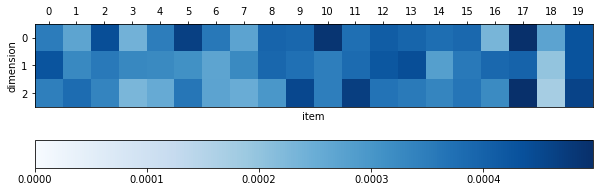

In [8]:
fig, ax = plt.subplots(figsize=(10,4))

plt.imshow(factor.encoding_matrix().numpy().T, vmin=0, cmap="Blues")
plt.xticks(np.arange(D))
ax.set_xlabel("item")
ax.set_ylabel("dimension")
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = True, labeltop=True)
plt.yticks(np.arange(P))
plt.colorbar(orientation = "horizontal")
plt.show()


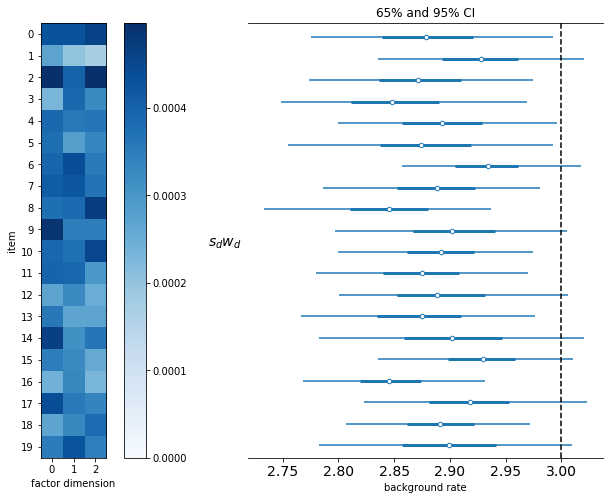

In [9]:
fig, ax = plt.subplots(1,2, figsize=(14,8))

pcm = ax[0].imshow(factor.encoding_matrix().numpy()[::-1,:], vmin=0, cmap="Blues")
ax[0].set_yticks(np.arange(D))
ax[0].set_yticklabels(np.arange(D))
ax[0].set_ylabel("item")
ax[0].set_xlabel("factor dimension")
ax[0].set_xticks(np.arange(P))
ax[0].set_xticklabels(np.arange(P))

fig.colorbar(pcm, ax=ax[0], orientation = "vertical")
az.plot_forest(intercept_data, ax=ax[1])
ax[1].set_xlabel("background rate")
ax[1].set_ylim((-0.014,.466))
ax[1].set_title("65% and 95% CI")
ax[1].axvline(3.0, linestyle='dashed', color="black")
plt.savefig('noise_factorization_sepmf.pdf', bbox_inches='tight')
plt.show()


The values in the factor encoding matrix as near zero. There is a gradient because the model induces a dimensional decay to remove symmetries - this encourages the leading dimensions to hold more of the signal.

In [10]:
factor.calibrated_expectations['s']/tf.reduce_sum(factor.calibrated_expectations['s'], axis=0, keepdims=True)

<tf.Tensor: shape=(2, 20), dtype=float64, numpy=
array([[5.55340783e-04, 4.88022769e-04, 6.08527930e-04, 4.45565622e-04,
        5.53583459e-04, 5.80796891e-04, 4.85448677e-04, 4.07464574e-04,
        5.48561262e-04, 6.55232406e-04, 6.06814915e-04, 5.89765986e-04,
        6.21201824e-04, 6.33761701e-04, 4.65155957e-04, 5.53999254e-04,
        5.45714805e-04, 7.06223561e-04, 3.74717515e-04, 6.82839262e-04],
       [9.99444659e-01, 9.99511977e-01, 9.99391472e-01, 9.99554434e-01,
        9.99446417e-01, 9.99419203e-01, 9.99514551e-01, 9.99592535e-01,
        9.99451439e-01, 9.99344768e-01, 9.99393185e-01, 9.99410234e-01,
        9.99378798e-01, 9.99366238e-01, 9.99534844e-01, 9.99446001e-01,
        9.99454285e-01, 9.99293776e-01, 9.99625282e-01, 9.99317161e-01]])>

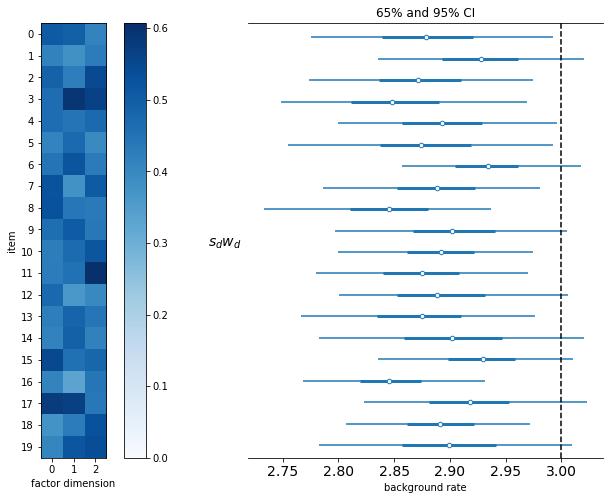

In [11]:
fig, ax = plt.subplots(1,2, figsize=(14,8))

pcm = ax[0].imshow(factor.decoding_matrix().numpy().T[::-1,:], vmin=0, cmap="Blues")
ax[0].set_yticks(np.arange(D))
ax[0].set_yticklabels(np.arange(D))
ax[0].set_ylabel("item")
ax[0].set_xlabel("factor dimension")
ax[0].set_xticks(np.arange(P))
ax[0].set_xticklabels(np.arange(P))

fig.colorbar(pcm, ax=ax[0], orientation = "vertical")
az.plot_forest(intercept_data, ax=ax[1])
ax[1].set_xlabel("background rate")
ax[1].set_ylim((-0.014,.466))
ax[1].set_title("65% and 95% CI")
ax[1].axvline(3.0, linestyle='dashed', color="black")
plt.show()
